In [58]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [57]:
def generate(x, y):
    x_c = x.clone()
    x_c[:, :10] *= 0.0
    x_c[range(x.shape[0]), y] = x.max()
    return x_c

In [56]:
class Net(torch.nn.Module):
    def __init__(self, dims):
        super().__init__()
        self.layers = []
        self.linear_classifier = LinearClassifier(1000, 10)
        self.linear_classifier.to("cuda")

        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1]).cuda()]
    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = generate(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)


    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h_pos, h_neg = layer.train(h_pos, h_neg)
    def train_last_layer(self,x,y):
        outputs = []
        for layer in self.layers:
            x = layer(x)
            outputs.append(x)
        concatenated_output = torch.cat(outputs, dim=1)
        self.linear_classifier.train_weights(concatenated_output, y)
    def predictu(self,x):
      outputs = []
      for layer in self.layers:
            x = layer(x)
            outputs.append(x)
      concatenated_output = torch.cat(outputs, dim=1)
      return self.linear_classifier.predict(concatenated_output)



In [59]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearClassifier, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

    def train_weights(self, x, y, num_epochs=100, learning_rate=0.01):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            outputs = self(x)
            loss = criterion(outputs, y)

            loss.backward(retain_graph=True)
            optimizer.step()

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    def predict(self, x):
        with torch.no_grad():
            outputs = self(x)
            probabilities = nn.functional.softmax(outputs, dim=1)
            _, predicted_class = torch.max(probabilities, 1)
        return predicted_class

In [60]:
import torch
import torch.nn as nn
from torch.optim import Adam

class Layer(nn.Linear):
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()

        self.opt = Adam(self.parameters(), lr=0.02)
        self.threshold = 1.0
        self.num_epochs = 1000


    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg):
        for i in range(self.num_epochs):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([self.threshold - g_pos, g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()






100%|██████████| 9912422/9912422 [00:00<00:00, 138021197.45it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44258565.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53816816.05it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7562734.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



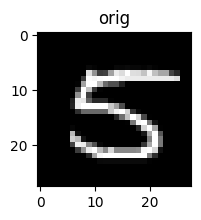

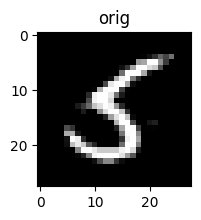

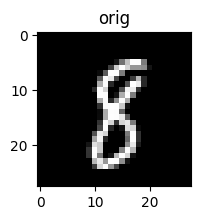

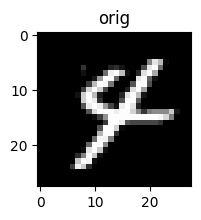

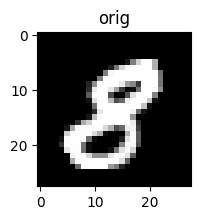

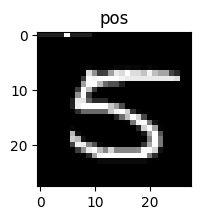

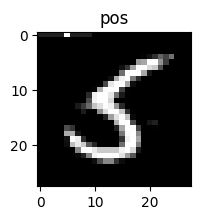

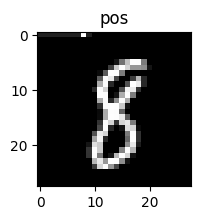

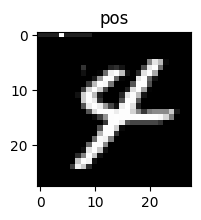

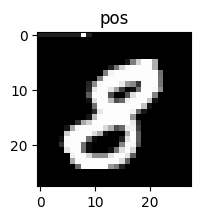

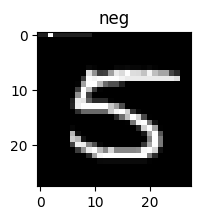

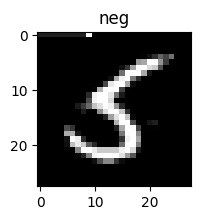

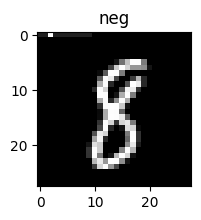

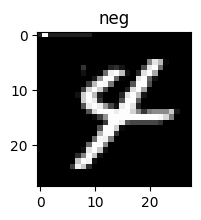

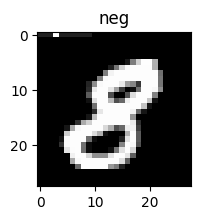

training layer 0 ...
training layer 1 ...
train error: 0.08432501554489136
train accuracy: 0.9156749844551086
test error: 0.08490002155303955
test accuracy: 0.9150999784469604


In [ ]:
torch.manual_seed(1234)
transform = Compose([ToTensor(),Normalize((0.1307,), (0.3081,)),Lambda(lambda x: torch.flatten(x))])

train_loader = DataLoader(MNIST('./data/', train=True,download=True,transform=transform),batch_size=40000, shuffle=True)

test_loader = DataLoader(MNIST('./data/', train=False,download=True,transform=transform),batch_size=10000, shuffle=False)


net = Net([784, 500, 500])
x, y = next(iter(train_loader))
x, y = x.cuda(), y.cuda()
x_pos = generate(x, y)
rnd = torch.randperm(x.size(0))
x_neg = generate(x, y[rnd])


net.train(x_pos, x_neg)

print('train error:', 1.0 - net.predict(x).eq(y).float().mean().item())
train_accuracy = net.predict(x).eq(y).float().mean().item()
print('train accuracy:', train_accuracy)
x_te, y_te = next(iter(test_loader))
x_te, y_te = x_te.cuda(), y_te.cuda()

print('test error:', 1.0 - net.predict(x_te).eq(y_te).float().mean().item())
test_accuracy = net.predict(x_te).eq(y_te).float().mean().item()
print('test accuracy:', test_accuracy)

تابع لاس درواقع می خواهد توان نمایی ها را کم بکند و این به منزله کم کردن گئنس برای داده های منفی و زیاد کردن گودنس برای داده های مثبت می باشد.

و این انتخاب نیز برای کانوکس بودن تابع لاس می باشد.

توضیحات تکمیلی از بینگ:
کد داده شده میانگین عملگر log-sum-exp را بر روی دو مجموعه از مقادیر: g_pos و g_neg محاسبه می کند. در زیر توضیحاتی در مورد این کد ارائه شده است:

self.threshold - g_pos: این عبارت تفاوت بین یک مقدار آستانه و tensor g_pos را محاسبه می کند.
g_neg - self.threshold: این عبارت تفاوت بین tensor g_neg و همان مقدار آستانه را محاسبه می کند.
torch.cat([self.threshold - g_pos, g_neg - self.threshold]): این عبارت دو tensor از مراحل 1 و 2 را به یک tensor ترکیب می کند.
torch.exp(torch.cat([self.threshold - g_pos, g_neg - self.threshold])): این عبارت تابع نمایی را بر روی هر عنصر tensor مرحله 3 اعمال می کند.
torch.log(1 + torch.exp(torch.cat([self.threshold - g_pos, g_neg - self.threshold]))): این عبارت لگاریتم طبیعی را بر روی نتیجه 1 به علاوه tensor مرحله 4 اعمال می کند. این معادل با محاسبه log-sum-exp است.
.mean(): این عبارت میانگین (average) تمام عناصر tensor مرحله 5 را محاسبه می کند.
این نوع عملیات اغلب در یادگیری ماشین برای محاسبه توابع خطا استفاده می شود، به خصوص در مواردی که پیش بینی های مدل (g_pos و g_neg) با یک آستانه مقایسه می شوند. عملگر log-sum-exp به دستگاه کمک می کند تا مقادیر بزرگ را کنترل کند و از underflow یا overflow عددی جلوگیری کند. این یک تقریب صاف برای تابع بیشینه است که در الگوریتم های مختلف یادگیری ماشین مفید است.

مقادیر خطا بر روی داده های تست و ترین در اخرین کد ذخیره شده است.
و اما نحوه پیاده سازی کد:
همانطور که در کقاله هم اورده شده بود ما وکتور لیبل را بالای عکس قرار می دهیم که این کار را با تابع 
generate
انجام داده ایم


و هر دفعه با یک داده درست یک داده فلط که صرفا لیبل آن رندم می باشد را به تابع لاس میدهیم و آن را برای کمینه کردن لاس آموزش می دهیم.



بعد از اموزش دادن شبکه نوبت به تست کردن آن میرسد که با تابع
predict
آن را انجام داده ایم
که می آید 10 تا لیبل مختلف را برای عکس میگذارد و درنهایت برای همه گودنس را حساب میکند و لیبل پیشنهادی لیبلی است که باعث شده مجموع گودنس های همه لایه هاماکس بشود